# MedMINIST-Pneumonia

Il seguente notebook illustra vari modelli per l'individuazione di soggetti positivi alla polmonite a partire da radiografie del torace in formato MNIST.

In [1]:
import tensorflow as tf

assert tf.__version__ >= "2.16"

import keras_tuner as kt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    make_scorer,
    f1_score,
    accuracy_score,
    precision_recall_fscore_support,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

from imblearn.over_sampling import RandomOverSampler, SMOTE

tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)

2024-08-27 17:55:21.409996: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-27 17:55:21.421171: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-27 17:55:21.433265: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-27 17:55:21.436925: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-27 17:55:21.445315: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# plot functions

plt.style.use("fivethirtyeight")
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.serif"] = "Ubuntu"
plt.rcParams["font.monospace"] = "Ubuntu Mono"
plt.rcParams["font.size"] = 10
plt.rcParams["axes.labelsize"] = 10
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titlesize"] = 10
plt.rcParams["xtick.labelsize"] = 8
plt.rcParams["ytick.labelsize"] = 8
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["figure.titlesize"] = 12
plt.rcParams["image.cmap"] = "jet"
plt.rcParams["image.interpolation"] = "none"
plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["lines.markersize"] = 8


def plot_measure(history_train, history_test, title="", xticks=None):
    plt.figure(figsize=(12, 8))
    plt.plot(history_train, marker="o", markersize=5, label="Train")
    plt.plot(history_test, marker="o", markersize=5, label="Validation")
    plt.legend()
    if xticks is None:
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
    else:
        # plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax = plt.subplot(111)
        ax.set_xlim(xticks[0], xticks[-1])
        plt.xticks(xticks)
    plt.title(title)
    plt.show()


def plot_confusion_matrix(train_labels, predictions_train):
    plt.figure(figsize=(12, 6))
    disp = ConfusionMatrixDisplay.from_predictions(
        train_labels, predictions_train, normalize="true", cmap="Blues"
    )
    disp.figure_.suptitle("Confusion Matrix")
    plt.grid(None)
    plt.show()

In [3]:
# utilis function


def print_accuracy_scores(
    train_labels, test_labels, predictions_train_model, predictions_test_model
):
    acc_train = accuracy_score(train_labels, predictions_train_model)
    acc_test = accuracy_score(test_labels, predictions_test_model)
    print("Training set accuracy:   {:.3f}".format(acc_train))
    print("Test set accuracy:       {:.3f}".format(acc_test))


def print_stats(labels, predictions, title):
    meas = precision_recall_fscore_support(
        labels, predictions, average=None, zero_division=np.nan
    )
    print(title)
    for i in range(2):
        print(
            "Class {0:d}: precision={1:5.3f}, recall={2:5.3f}, f1_score={3:5.3f}".format(
                i, meas[0][i], meas[1][i], meas[2][i]
            )
        )


def train_validation_test_split(images, labels, test_val_size, verbose=False):
    train_images, test_val_images, train_labels, test_val_labels = train_test_split(
        images, labels, test_size=test_val_size, random_state=42
    )
    val_images, test_images, val_labels, test_labels = train_test_split(
        test_val_images, test_val_labels, test_size=0.5, random_state=42
    )

    if verbose:
        try:
            print(
                f"Shape of training set of images:    {train_images.shape}\t\timages of size {train_images.shape[1]}x{train_images.shape[2]}"
            )
            print(
                f"Shape of validation set of images:  {val_images.shape}\t\timages of size {val_images.shape[1]}x{val_images.shape[2]}"
            )
            print(
                f"Shape of test set of images:        {test_images.shape}\t\timages of size {test_images.shape[1]}x{test_images.shape[2]}"
            )
            nb_classes = np.unique(train_labels).shape[0]
            print(f"Number of classes: {nb_classes}")
        except IndexError:
            print(f"Shape of training set of images:    {train_images.shape}")
            print(f"Shape of validation set of images:  {val_images.shape}")
            print(f"Shape of test set of images:        {test_images.shape}")
            nb_classes = np.unique(train_labels).shape[0]
            print(f"Number of classes: {nb_classes}")

    return train_images, train_labels, val_images, val_labels, test_images, test_labels

In [4]:
# load dataset

X = np.load("pneumonia_images.npy")
y = (np.load("pneumonia_labels.npy")).ravel()

if len(X) != len(y):
    raise ValueError("Numbers of images and labels do not match")

print(f"The dataset is composed by {X.shape[0]} images {X.shape[1]}x{X.shape[2]}")

bin_count = np.bincount(y)
if len(bin_count) != 2:
    raise ValueError("Labels must be 0 or 1")

print("Negative examples: ", bin_count[0])
print("Positive examples: ", bin_count[1])

if bin_count[0] != bin_count[1]:
    print("Imbalanced Dataset")
else:
    print("Balanced Dataset")

x_negative = next((i for i, x in enumerate(X) if y[i] == 0), None)
x_positive = next((i for i, x in enumerate(X) if y[i] == 1), None)

The dataset is composed by 5232 images 28x28
Negative examples:  1349
Positive examples:  3883
Imbalanced Dataset


## Il dataset

Il dataset viene fornite tramite due file .npy contente le immagini e le rispettive etichette. Data la mancaza di documentazione si assume, banalmente, l'etichetta 0 come negativo e 1 come positivo.
Dall'analisi del dataset è evidente uno sbilanciamento tra le classi:
- 1349 elementi negativi;
- 3883 elementi positivi.

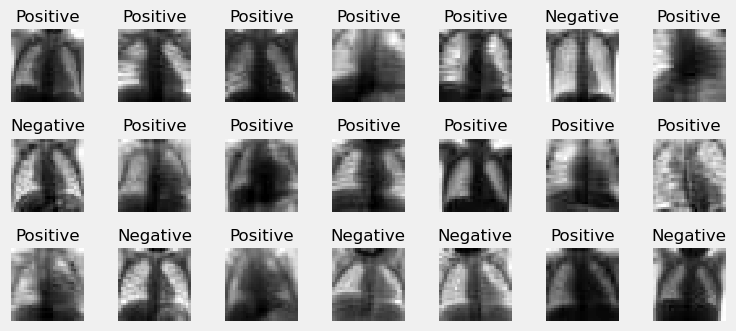

In [5]:
# print examples

n_rows = 3
n_cols = 7
titles = ["Negative", "Positive"]
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X[index], cmap="binary", interpolation="nearest")
        plt.axis("off")
        plt.title(titles[y[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

## Istogrammi

Il primo approccio applicato è quello degli istogrammi della tonalità di grigio. Da una breve visione delle immagine è evidente una tendenza al bianco delle radiografie dei soggetti malati. Questa è un'operazione di riduzione delle feature, dai 784 pixel di cui è composta l'immagine siamo passati al numero dei bin.
Si è deciso di procedere all'analisi su istogrammi da 8, 16, 32 e 64 bin per i seguenti modelli:
- Logistic Regression;
- Random Forest;
  SVC.
  
Per quando riguarda lo sbilanciamento tra le classi si è deciso di confrontare 3 soluzioni possibili:
- aggiungere un peso agli elementi delle classi (Weighted);
- Oversampling;
- SMOTE.

Il primo viene offerto da *scikit-learn* tramite il parametro *class_weight*; è sufficiente passare a questo parametro la stringa "balanced".

L'oversamplig è una tecnica che consiste nel bilanciare le classi tramite la duplicazione degli elementi della classe minoritaria.

SMOTE (Synthetic Minority Over-sampling Technique) è un metodo di oversampling che crea elementi sintetici tramite interpolazione dei vicini, nello spazio delle feature, degli elementi della classe minoritaria.

La ricerca degli iperparametri viene effetuata tramite Keras Tuner utilizzando SklearnTuner e il GridSearchOracle. L'80% del dataset viene destinato al Training Set e il rimanente al Test Set. Tutto il Trainig Set viene utilizzato per il tuning degli iperparametri che usa una cross validation con un StrafiedKFold con 5 fold. Come indicato dalla documentazione di Keras Tuner, una volta identificati i migliori iperparametri viene effetuato un nuovo training su tutto il Training Set.

In [6]:
def extract_histogram(
    image,
    color_space,
    channels=(0, 1, 2),
    bins=(8, 8, 8),
    range=(0, 256, 0, 256, 0, 256),
):
    if color_space is None:
        cvt_img = image
    else:
        cvt_img = cv2.cvtColor(image, color_space)
    hist = cv2.calcHist([cvt_img], channels, None, bins, range)
    cv2.normalize(hist, hist)
    return hist.flatten()


def get_histograms(dataset, color_space, channels, bins, channels_range):
    histograms = []
    for x in dataset:
        hist = extract_histogram(x, color_space, channels, bins, channels_range)
        histograms.append(hist)
    return histograms


def ranges(N, nb):
    step = N / nb
    return ["{},{}".format(round(step * i), round(step * (i + 1))) for i in range(nb)]

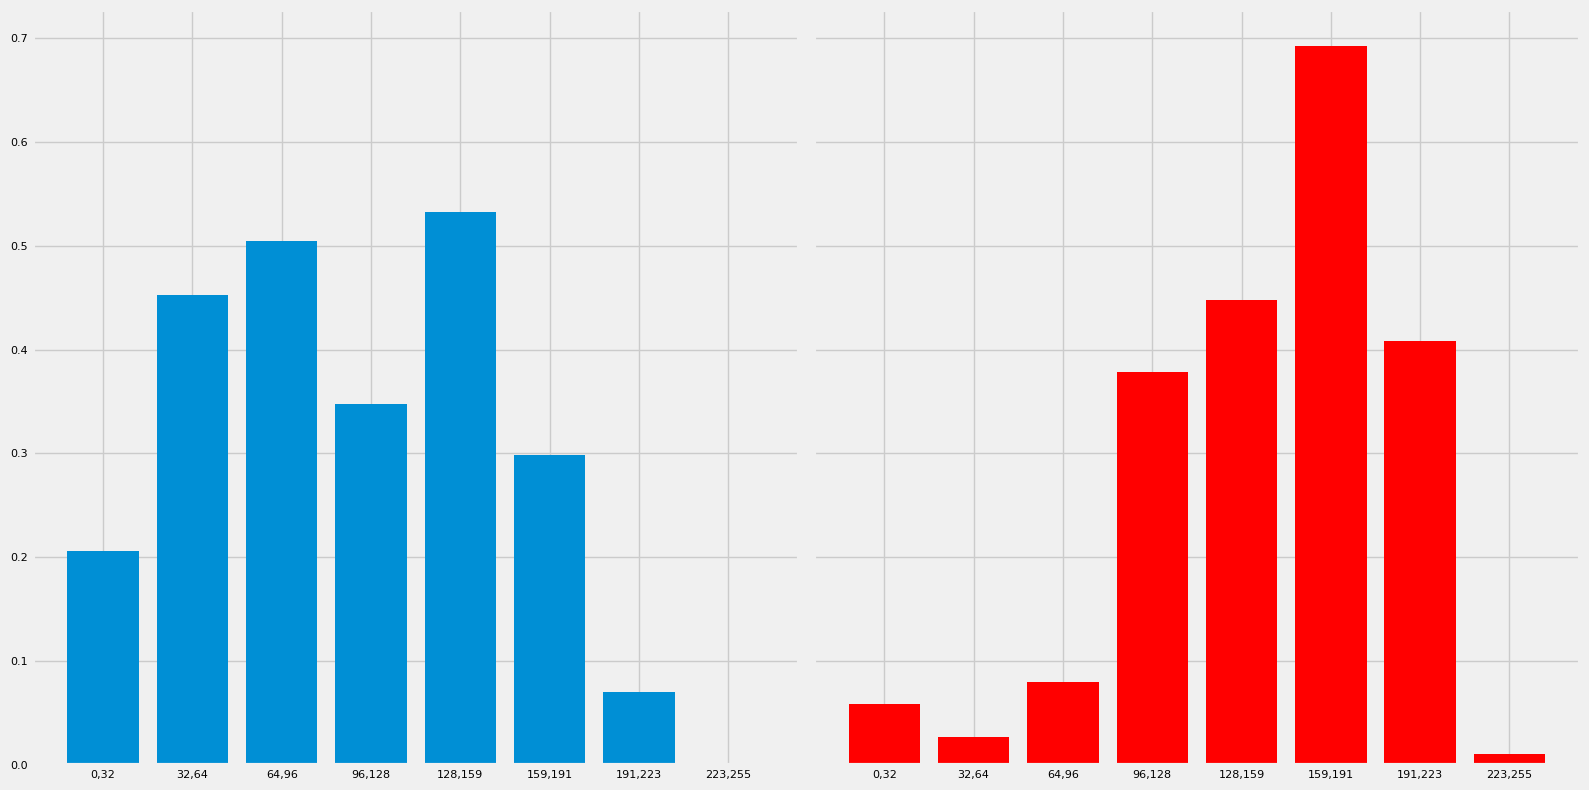

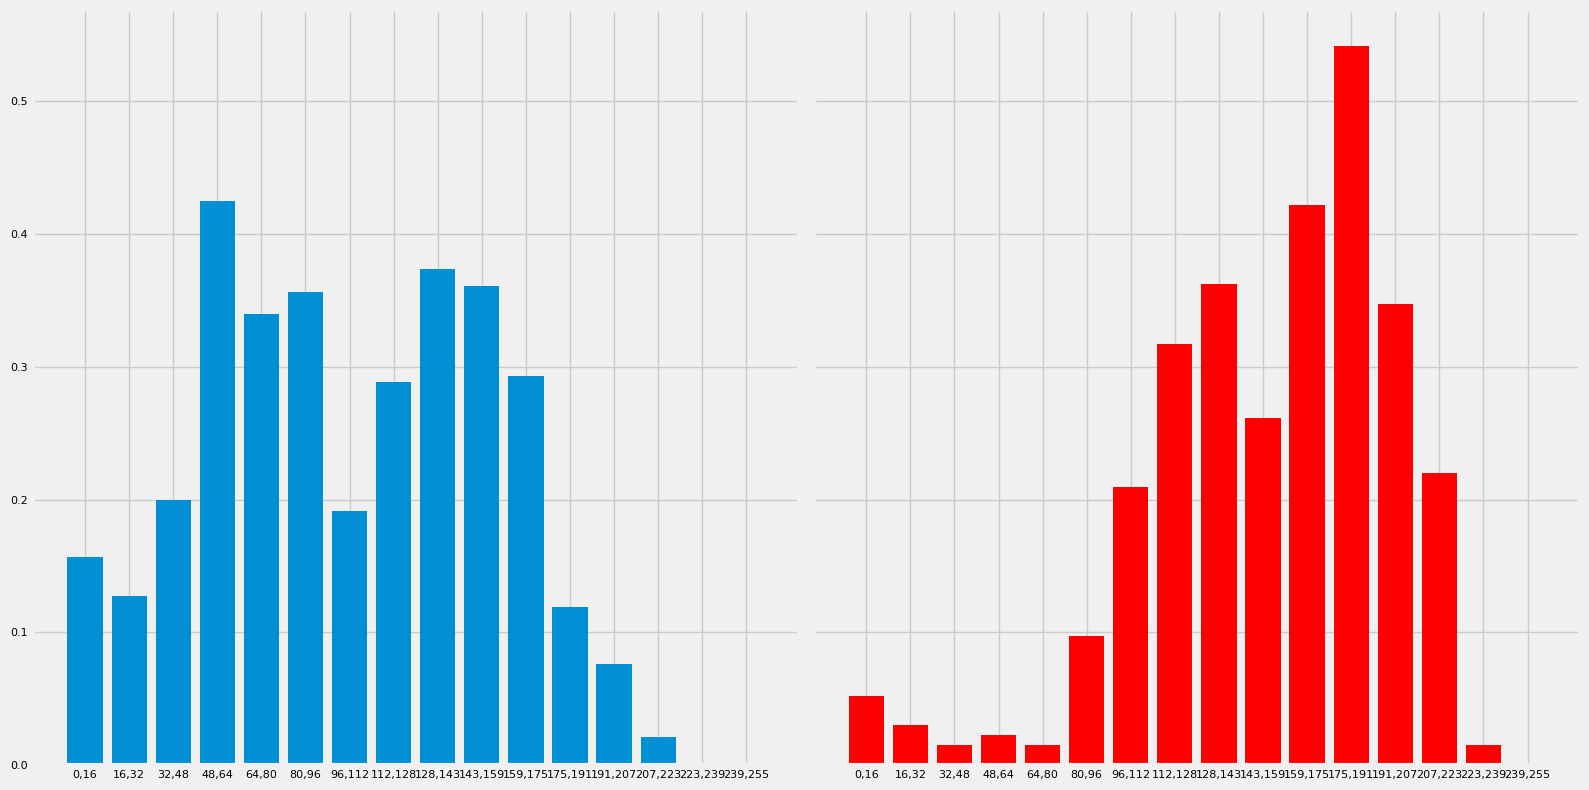

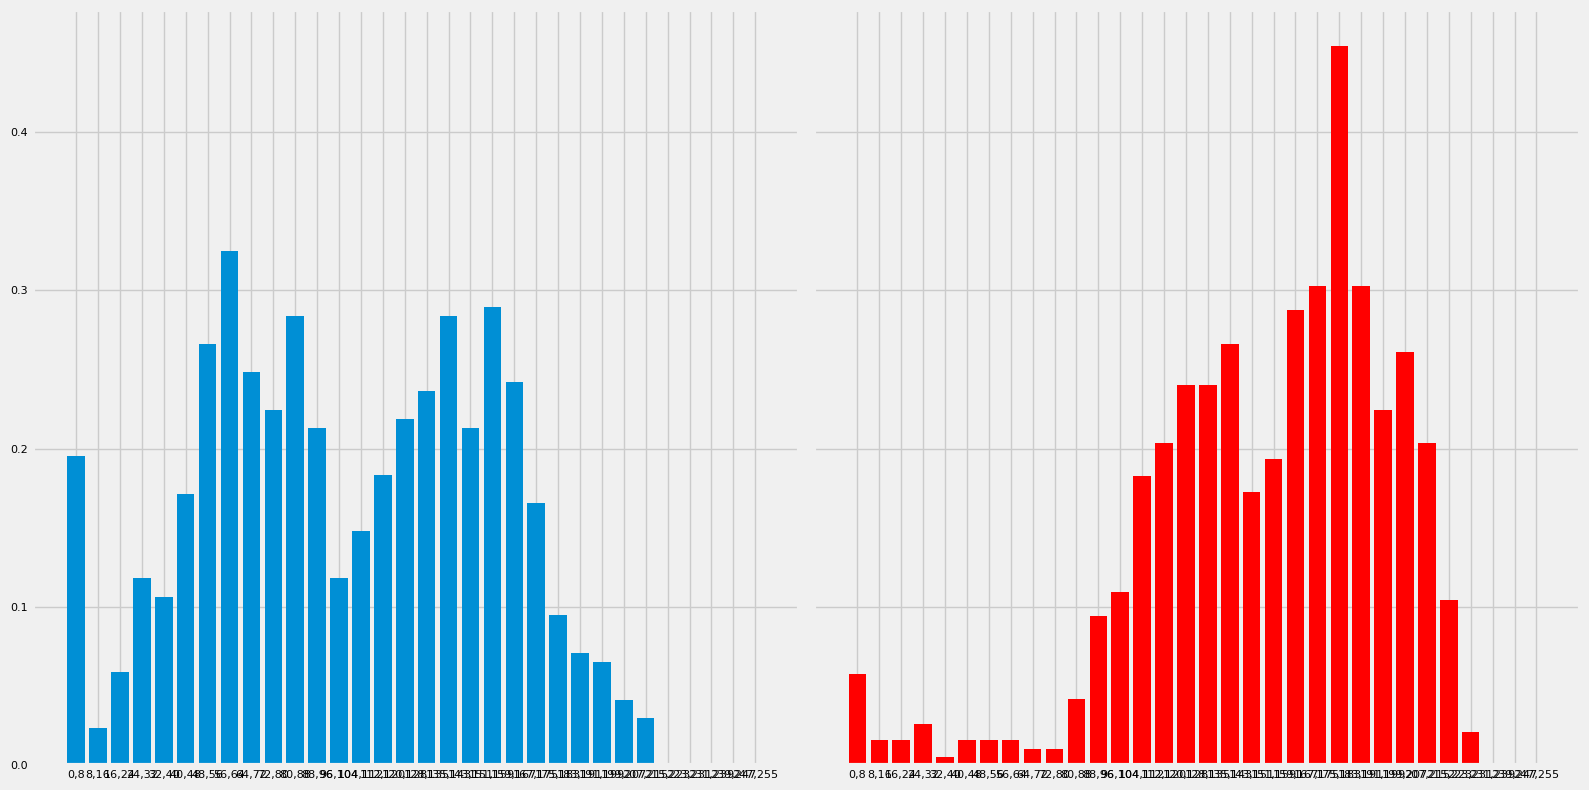

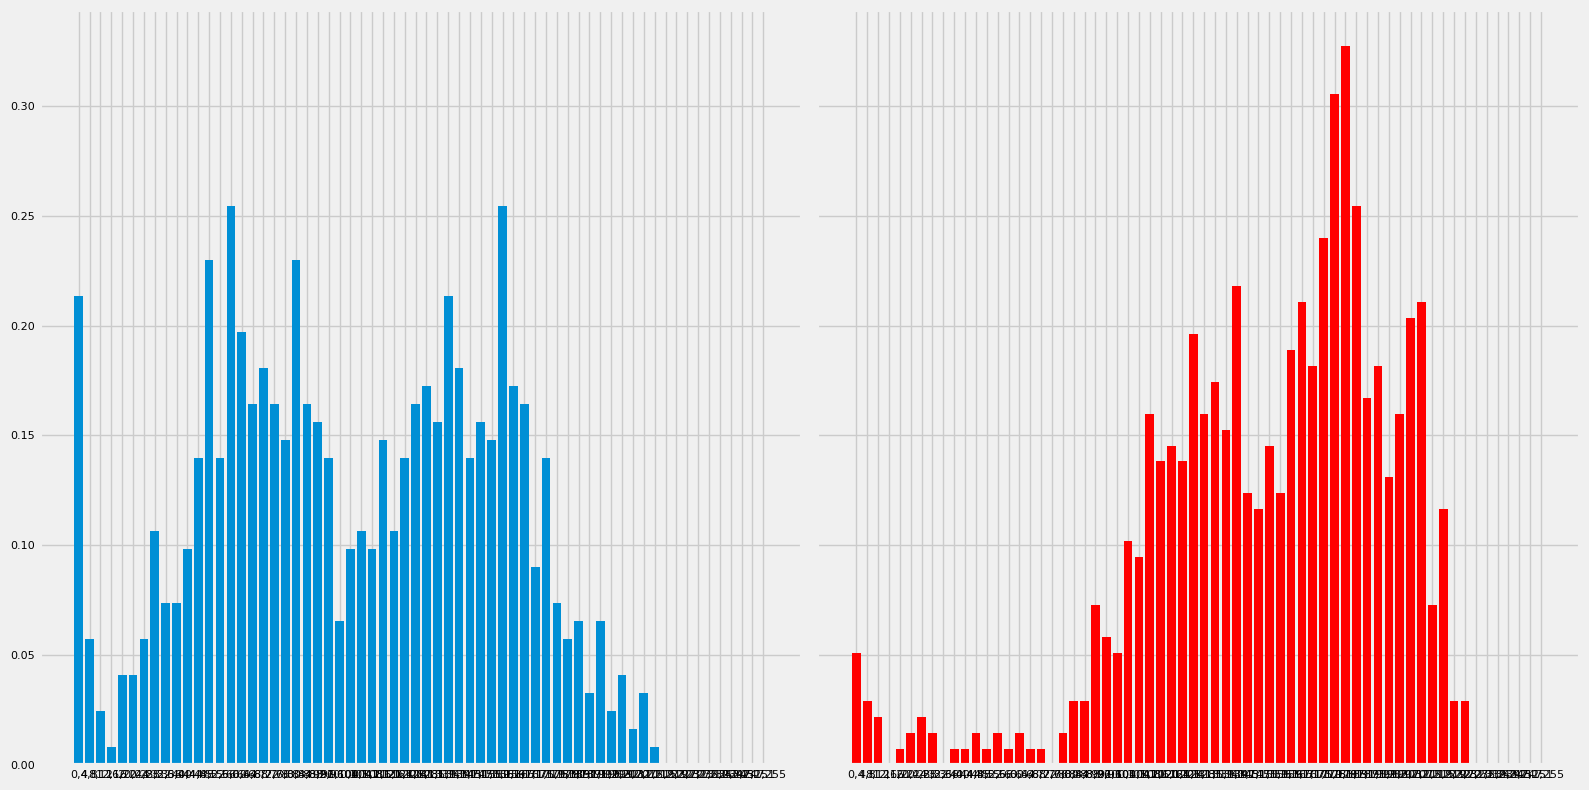

In [7]:
# negative
hist8bins_negative = extract_histogram(X[x_negative], None, (0,), (8,), (0, 256))
hist16bins_negative = extract_histogram(X[x_negative], None, (0,), (16,), (0, 256))
hist32bins_negative = extract_histogram(X[x_negative], None, (0,), (32,), (0, 256))
hist64bins_negative = extract_histogram(X[x_negative], None, (0,), (64,), (0, 256))

# positive
hist8bins__positive = extract_histogram(X[x_positive], None, (0,), (8,), (0, 256))
hist16bins_positive = extract_histogram(X[x_positive], None, (0,), (16,), (0, 256))
hist32bins_positive = extract_histogram(X[x_positive], None, (0,), (32,), (0, 256))
hist64bins_positive = extract_histogram(X[x_positive], None, (0,), (64,), (0, 256))

# 8 bins
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].bar(ranges(255, 8), hist8bins_negative)
axs[1].bar(ranges(255, 8), hist8bins__positive, color="red")
plt.show()

# 16 bins
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].bar(ranges(255, 16), hist16bins_negative)
axs[1].bar(ranges(255, 16), hist16bins_positive, color="red")
plt.show()

# 32 bins
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].bar(ranges(255, 32), hist32bins_negative)
axs[1].bar(ranges(255, 32), hist32bins_positive, color="red")
plt.show()

# 64 bins
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].bar(ranges(255, 64), hist64bins_negative)
axs[1].bar(ranges(255, 64), hist64bins_positive, color="red")
plt.show()

In [8]:
bins_8 = np.array(get_histograms(X, None, (0,), (8,), (0, 256)))
bins_16 = np.array(get_histograms(X, None, (0,), (16,), (0, 256)))
bins_32 = np.array(get_histograms(X, None, (0,), (32,), (0, 256)))
bins_64 = np.array(get_histograms(X, None, (0,), (64,), (0, 256)))

ros = RandomOverSampler(random_state=42)
bins_8_over, y_over = ros.fit_resample(bins_8, y)
bins_16_over, y_over = ros.fit_resample(bins_16, y)
bins_32_over, y_over = ros.fit_resample(bins_32, y)
bins_64_over, y_over = ros.fit_resample(bins_64, y)

sm = SMOTE(random_state=42)
bins_8_smote, y_smote = sm.fit_resample(bins_8, y)
bins_16_smote, y_smote = sm.fit_resample(bins_16, y)
bins_32_smote, y_smote = sm.fit_resample(bins_32, y)
bins_64_smote, y_smote = sm.fit_resample(bins_64, y)

Dato il problema medico si è posta l'attenzione non sull'accuracy, ma sulla recall della classe 1, i positivi, poichè è auspicabicale l'individuazione del malato a discapito di un sano che venga classificato erroneamente. Dato che il tuning degli iperparametri cercando la massimizzazione della recll della classe 1 portava spesso ad asseggnare tutti gli elementi a quella classe si è prefirito utilizzare f1_score come metrica da massimizzare.

Dai tre metodi di bilanciamento ci si aspettato diversi risultati nelle metriche precision, recall e F1. Per esempio SMOTE tende a favorire la classe minoritaria che in questo caso è quella meno interessante per la nostra classificazione.

In [9]:
scorer = make_scorer(f1_score, pos_label=1, labels=[0, 1])

### Logistic Regression

Per la regressione logistica, la ricerca si è concentrata sulla penalità applicata al modello e sul suo peso.

Utilizzando il solver **saga**, tra i tipi di regolarizzazione è possibile scegliere tra L1 (Lasso), L2 (Ridge) ed Elastic-Net. Elastic-Net permette di utlizzare L1 e L2 insieme pesando le 2 componenti tramite il parametro *l1_ratio*. Il valore di *l1_ratio* è compreso tra 0 e , dove 0 corrisponde a L2 e 1 a L1.

Gli iperparametri esaminati durante il tuning sono quindi 2:
- **C**, l'inverso del peso della penalità;
- **l1_ratio**. 

In [10]:
def log_reg(project_name, data, labels, title, class_weight=None):

    def build_logistic_regression(hp):
        model = LogisticRegression(
            n_jobs=-1,
            random_state=42,
            class_weight=class_weight,
            C=hp.Choice("C", [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]),
            solver="saga",
            penalty="elasticnet",
            l1_ratio=hp.Choice(
                "l1_ratio", [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
            ),
            max_iter=200,
        )
        return model

    tuner = kt.tuners.SklearnTuner(
        oracle=kt.oracles.GridSearchOracle(objective=kt.Objective("score", "max")),
        scoring=scorer,
        hypermodel=build_logistic_regression,
        cv=StratifiedKFold(5),
        project_name=project_name,
    )

    X_train, X_test, y_train, y_test = train_test_split(
        data, labels, test_size=0.2, random_state=42
    )

    tuner.search(X_train, y_train)

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    print(f"\n{title}\n")

    print("Best C: ", best_hps.get("C"))
    print("Best l1_ratio: ", best_hps.get("l1_ratio"))

    print()

    model0 = tuner.hypermodel.build(best_hps)
    model0.fit(X_train, y_train)

    predictions_test = model0.predict(X_test)
    predictions_train = model0.predict(X_train)

    print_accuracy_scores(y_train, y_test, predictions_train, predictions_test)
    print_stats(y_train, predictions_train, "Training set")
    print_stats(y_test, predictions_test, "Test set")

In [11]:
log_reg(
    "tuners/log_reg_hist_8bins_weighted",
    bins_8,
    y,
    "Logistic Regression 8 bins weighted",
    "balanced",
)

Reloading Tuner from ./tuners/log_reg_hist_8bins_weighted/tuner0.json

Logistic Regression 8 bins weighted

Best C:  1.0
Best l1_ratio:  1.0

Training set accuracy:   0.810
Test set accuracy:       0.796
Training set
Class 0: precision=0.594, recall=0.846, f1_score=0.698
Class 1: precision=0.937, recall=0.797, f1_score=0.862
Test set
Class 0: precision=0.568, recall=0.808, f1_score=0.667
Class 1: precision=0.924, recall=0.792, f1_score=0.853


In [12]:
log_reg(
    "tuners/log_reg_hist_8bins_over",
    bins_8_over,
    y_over,
    "Logistic Regression 8 bins oversampling",
)

Reloading Tuner from ./tuners/log_reg_hist_8bins_over/tuner0.json

Logistic Regression 8 bins oversampling

Best C:  1.0
Best l1_ratio:  0.9

Training set accuracy:   0.817
Test set accuracy:       0.817
Training set
Class 0: precision=0.800, recall=0.843, f1_score=0.821
Class 1: precision=0.837, recall=0.793, f1_score=0.814
Test set
Class 0: precision=0.815, recall=0.835, f1_score=0.825
Class 1: precision=0.820, recall=0.798, f1_score=0.809


In [13]:
log_reg(
    "tuners/log_reg_hist_8bins_smote",
    bins_8_smote,
    y_smote,
    "Logistic Regression 8 bins SMOTE",
)

Reloading Tuner from ./tuners/log_reg_hist_8bins_smote/tuner0.json

Logistic Regression 8 bins SMOTE

Best C:  1.0
Best l1_ratio:  1.0

Training set accuracy:   0.822
Test set accuracy:       0.819
Training set
Class 0: precision=0.805, recall=0.845, f1_score=0.825
Class 1: precision=0.840, recall=0.798, f1_score=0.819
Test set
Class 0: precision=0.814, recall=0.840, f1_score=0.827
Class 1: precision=0.824, recall=0.795, f1_score=0.809


In [14]:
log_reg(
    "tuners/log_reg_hist_16bins_weighted",
    bins_16,
    y,
    "Logistic Regression 16 bins weighted",
    "balanced",
)

Reloading Tuner from ./tuners/log_reg_hist_16bins_weighted/tuner0.json

Logistic Regression 16 bins weighted

Best C:  1.0
Best l1_ratio:  1.0

Training set accuracy:   0.832
Test set accuracy:       0.818
Training set
Class 0: precision=0.626, recall=0.869, f1_score=0.728
Class 1: precision=0.947, recall=0.819, f1_score=0.878
Test set
Class 0: precision=0.601, recall=0.834, f1_score=0.698
Class 1: precision=0.935, recall=0.812, f1_score=0.869


In [15]:
log_reg(
    "tuners/log_reg_hist_16bins_over",
    bins_16_over,
    y_over,
    "Logistic Regression 16 bins oversampling",
)

Reloading Tuner from ./tuners/log_reg_hist_16bins_over/tuner0.json

Logistic Regression 16 bins oversampling

Best C:  1.0
Best l1_ratio:  1.0

Training set accuracy:   0.839
Test set accuracy:       0.838
Training set
Class 0: precision=0.821, recall=0.862, f1_score=0.841
Class 1: precision=0.857, recall=0.815, f1_score=0.836
Test set
Class 0: precision=0.835, recall=0.857, f1_score=0.846
Class 1: precision=0.843, recall=0.819, f1_score=0.831


In [16]:
log_reg(
    "tuners/log_reg_hist_16bins_smote",
    bins_16_smote,
    y_smote,
    "Logistic Regression 16 bins SMOTE",
)

Reloading Tuner from ./tuners/log_reg_hist_16bins_smote/tuner0.json

Logistic Regression 16 bins SMOTE

Best C:  1.0
Best l1_ratio:  1.0

Training set accuracy:   0.843
Test set accuracy:       0.848
Training set
Class 0: precision=0.823, recall=0.870, f1_score=0.846
Class 1: precision=0.865, recall=0.816, f1_score=0.840
Test set
Class 0: precision=0.839, recall=0.873, f1_score=0.856
Class 1: precision=0.858, recall=0.822, f1_score=0.840


In [17]:
log_reg(
    "tuners/log_reg_hist_32bins_weighted",
    bins_32,
    y,
    "Logistic Regression 32 bins weighted",
    "balanced",
)

Reloading Tuner from ./tuners/log_reg_hist_32bins_weighted/tuner0.json

Logistic Regression 32 bins weighted

Best C:  1.0
Best l1_ratio:  1.0

Training set accuracy:   0.836
Test set accuracy:       0.819
Training set
Class 0: precision=0.633, recall=0.867, f1_score=0.732
Class 1: precision=0.947, recall=0.825, f1_score=0.881
Test set
Class 0: precision=0.603, recall=0.838, f1_score=0.701
Class 1: precision=0.937, recall=0.813, f1_score=0.871


In [18]:
log_reg(
    "tuners/log_reg_hist_32bins_over",
    bins_32_over,
    y_over,
    "Logistic Regression 32 bins oversampling",
)

Reloading Tuner from ./tuners/log_reg_hist_32bins_over/tuner0.json

Logistic Regression 32 bins oversampling

Best C:  1.0
Best l1_ratio:  0.9

Training set accuracy:   0.845
Test set accuracy:       0.846
Training set
Class 0: precision=0.827, recall=0.870, f1_score=0.848
Class 1: precision=0.865, recall=0.821, f1_score=0.843
Test set
Class 0: precision=0.842, recall=0.864, f1_score=0.853
Class 1: precision=0.851, recall=0.827, f1_score=0.839


In [19]:
log_reg(
    "tuners/log_reg_hist_32bins_smote",
    bins_32_smote,
    y_smote,
    "Logistic Regression 32 bins SMOTE",
)

Reloading Tuner from ./tuners/log_reg_hist_32bins_smote/tuner0.json

Logistic Regression 32 bins SMOTE

Best C:  1.0
Best l1_ratio:  0.9

Training set accuracy:   0.849
Test set accuracy:       0.849
Training set
Class 0: precision=0.831, recall=0.874, f1_score=0.852
Class 1: precision=0.869, recall=0.825, f1_score=0.846
Test set
Class 0: precision=0.844, recall=0.868, f1_score=0.856
Class 1: precision=0.855, recall=0.828, f1_score=0.841


In [20]:
log_reg(
    "tuners/log_reg_hist_64bins_weighted",
    bins_64,
    y,
    "Logistic Regression 64 bins weighted",
    "balanced",
)

Reloading Tuner from ./tuners/log_reg_hist_64bins_weighted/tuner0.json

Logistic Regression 64 bins weighted

Best C:  1.0
Best l1_ratio:  1.0

Training set accuracy:   0.836
Test set accuracy:       0.816
Training set
Class 0: precision=0.633, recall=0.871, f1_score=0.733
Class 1: precision=0.948, recall=0.823, f1_score=0.881
Test set
Class 0: precision=0.596, recall=0.842, f1_score=0.698
Class 1: precision=0.938, recall=0.807, f1_score=0.867


In [21]:
log_reg(
    "tuners/log_reg_hist_64bins_over",
    bins_64_over,
    y_over,
    "Logistic Regression 64 bins oversampling",
)

Reloading Tuner from ./tuners/log_reg_hist_64bins_over/tuner0.json

Logistic Regression 64 bins oversampling

Best C:  1.0
Best l1_ratio:  1.0

Training set accuracy:   0.850
Test set accuracy:       0.851
Training set
Class 0: precision=0.831, recall=0.874, f1_score=0.852
Class 1: precision=0.870, recall=0.825, f1_score=0.847
Test set
Class 0: precision=0.840, recall=0.878, f1_score=0.859
Class 1: precision=0.863, recall=0.822, f1_score=0.842


In [22]:
log_reg(
    "tuners/log_reg_hist_64bins_smote",
    bins_64_smote,
    y_smote,
    "Logistic Regression 64 bins SMOTE",
)

Reloading Tuner from ./tuners/log_reg_hist_64bins_smote/tuner0.json

Logistic Regression 64 bins SMOTE

Best C:  1.0
Best l1_ratio:  1.0

Training set accuracy:   0.852
Test set accuracy:       0.846
Training set
Class 0: precision=0.833, recall=0.878, f1_score=0.855
Class 1: precision=0.873, recall=0.827, f1_score=0.849
Test set
Class 0: precision=0.837, recall=0.872, f1_score=0.854
Class 1: precision=0.857, recall=0.819, f1_score=0.838


In tutti i casi è stato selezionato durante il tuning la panalità L1 con il costo minore, tranne che per il caso SMOTE 64 bin (C =1.0, l1_ratio:  0.8).

Come ipotizzato, l'aumento del numero di feature ha portato a un miglioramento di tutte le metriche considerate fino a 32 bin.

Per quanto riguarda i tre metodi di bilanciamento, il risultato migliore sulla metrica utilizzata per il tuning è stato ottenuto applicando i pesi alle classi. Tuttavia, l'accuracy è risultata migliore con SMOTE, seguita dall'Oversampling, e infine dalla metodo dei pesi (Weighted).

È importante notare che, nel caso del metodo Weighted, c'è una significativa differenza tra la classe 0 e la classe 1 in termini di Precision, Recall e F1-Score. In tutti i casi, si osserva uno sbilanciamento notevole a favore della classe maggioritaria. Al contrario, con SMOTE si verifica l'effetto opposto come previsto.

### Random Forest

Il numero di parametri offerti da **RandomForestClassifier** è molto più ampio rispetto a quello del modello precedente. Per questo motivo, la ricerca degli iperparametri ottimali è stata limitata ai seguenti tre:
- **n_estimators**: il numero di alberi nella foresta.
- **max_depth**: la profondità massima degli alberi.
- **ccp_alpha**, parametro usato per il Minimal Cost-Complexity Pruning, una tecnica per rimuovere i nodi non foglia sotto una certa soglia di complessità.

Inoltre non viene permessa la formazioni di nodi foglia con un solo elemento.

In [23]:
def rand_forest(
    project_name,
    data,
    labels,
    title,
    class_weight=None,
    n_estimators=[100, 250],
    max_depth=[15, 20, 25],
    ccp_alpha=[0.0005, 0.001, 0.0015, 0.002],
):

    def build_random_forest(hp):
        model = RandomForestClassifier(
            n_estimators=hp.Choice("n_estimators", n_estimators),
            max_depth=hp.Choice("max_depth", max_depth),
            min_samples_leaf=2,
            ccp_alpha=hp.Choice("ccp_alpha", ccp_alpha),
            class_weight=class_weight,
            n_jobs=-1,
            random_state=42,
        )

        return model

    tuner = kt.tuners.SklearnTuner(
        oracle=kt.oracles.GridSearchOracle(objective=kt.Objective("score", "max")),
        scoring=scorer,
        hypermodel=build_random_forest,
        cv=StratifiedKFold(5),
        overwrite=False,
        project_name=project_name,
    )

    X_train, X_test, y_train, y_test = train_test_split(
        data, labels, test_size=0.2, random_state=42
    )

    tuner.search(X_train, y_train)

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    print(f"\n{title}\n")

    print("Best n_estimators:       ", best_hps.get("n_estimators"))
    print("Best max_depth:          ", best_hps.get("max_depth"))
    print("Best ccp_alpha:          ", best_hps.get("ccp_alpha"))

    print()

    model0 = tuner.hypermodel.build(best_hps)
    model0.fit(X_train, y_train)

    predictions_test = model0.predict(X_test)
    predictions_train = model0.predict(X_train)

    print_accuracy_scores(y_train, y_test, predictions_train, predictions_test)
    print_stats(y_train, predictions_train, "Training set")
    print_stats(y_test, predictions_test, "Test set")

In [24]:
rand_forest(
    "tuners/rand_forest_hist_8bins_weighted",
    bins_8,
    y,
    "Random Forest 8 bins weighted",
    "balanced",
)

Reloading Tuner from ./tuners/rand_forest_hist_8bins_weighted/tuner0.json

Random Forest 8 bins weighted

Best n_estimators:        100
Best max_depth:           25
Best ccp_alpha:           0.0005

Training set accuracy:   0.954
Test set accuracy:       0.874
Training set
Class 0: precision=0.880, recall=0.951, f1_score=0.914
Class 1: precision=0.982, recall=0.955, f1_score=0.968
Test set
Class 0: precision=0.755, recall=0.743, f1_score=0.749
Class 1: precision=0.913, recall=0.918, f1_score=0.916


In [25]:
rand_forest(
    "tuners/rand_forest_hist_8bins_over",
    bins_8_over,
    y_over,
    "Random Forest 8 bins oversampling",
)

Reloading Tuner from ./tuners/rand_forest_hist_8bins_over/tuner0.json

Random Forest 8 bins oversampling

Best n_estimators:        250
Best max_depth:           25
Best ccp_alpha:           0.0005

Training set accuracy:   0.952
Test set accuracy:       0.912
Training set
Class 0: precision=0.941, recall=0.964, f1_score=0.953
Class 1: precision=0.964, recall=0.941, f1_score=0.952
Test set
Class 0: precision=0.905, recall=0.926, f1_score=0.916
Class 1: precision=0.920, recall=0.896, f1_score=0.908


In [26]:
rand_forest(
    "tuners/rand_forest_hist_8bins_smote",
    bins_8_smote,
    y_smote,
    "Random Forest 8 bins SMOTE",
)

Reloading Tuner from ./tuners/rand_forest_hist_8bins_smote/tuner0.json

Random Forest 8 bins SMOTE

Best n_estimators:        250
Best max_depth:           20
Best ccp_alpha:           0.0005

Training set accuracy:   0.942
Test set accuracy:       0.894
Training set
Class 0: precision=0.936, recall=0.948, f1_score=0.942
Class 1: precision=0.948, recall=0.936, f1_score=0.942
Test set
Class 0: precision=0.907, recall=0.887, f1_score=0.897
Class 1: precision=0.882, recall=0.903, f1_score=0.892


In [27]:
rand_forest(
    "tuners/rand_forest_hist_16bins_weighted",
    bins_16,
    y,
    "Random Forest 16 bins weighted",
    "balanced",
)

Reloading Tuner from ./tuners/rand_forest_hist_16bins_weighted/tuner0.json

Random Forest 16 bins weighted

Best n_estimators:        250
Best max_depth:           15
Best ccp_alpha:           0.0005

Training set accuracy:   0.960
Test set accuracy:       0.897
Training set
Class 0: precision=0.888, recall=0.969, f1_score=0.926
Class 1: precision=0.989, recall=0.957, f1_score=0.973
Test set
Class 0: precision=0.785, recall=0.815, f1_score=0.800
Class 1: precision=0.937, recall=0.925, f1_score=0.931


In [28]:
rand_forest(
    "tuners/rand_forest_hist_16bins_over",
    bins_16_over,
    y_over,
    "Random Forest 16 bins oversampling",
)

Reloading Tuner from ./tuners/rand_forest_hist_16bins_over/tuner0.json

Random Forest 16 bins oversampling

Best n_estimators:        250
Best max_depth:           25
Best ccp_alpha:           0.0005

Training set accuracy:   0.967
Test set accuracy:       0.940
Training set
Class 0: precision=0.955, recall=0.979, f1_score=0.967
Class 1: precision=0.978, recall=0.955, f1_score=0.966
Test set
Class 0: precision=0.923, recall=0.965, f1_score=0.943
Class 1: precision=0.961, recall=0.914, f1_score=0.937


In [29]:
rand_forest(
    "tuners/rand_forest_hist_16bins_smote",
    bins_16_smote,
    y_smote,
    "Random Forest 16 bins SMOTE",
)

Reloading Tuner from ./tuners/rand_forest_hist_16bins_smote/tuner0.json

Random Forest 16 bins SMOTE

Best n_estimators:        250
Best max_depth:           20
Best ccp_alpha:           0.0005

Training set accuracy:   0.958
Test set accuracy:       0.918
Training set
Class 0: precision=0.953, recall=0.964, f1_score=0.958
Class 1: precision=0.964, recall=0.953, f1_score=0.959
Test set
Class 0: precision=0.919, recall=0.921, f1_score=0.920
Class 1: precision=0.916, recall=0.914, f1_score=0.915


In [30]:
rand_forest(
    "tuners/rand_forest_hist_32bins_weighted",
    bins_32,
    y,
    "Random Forest 32 bins weighted",
    "balanced",
)

Reloading Tuner from ./tuners/rand_forest_hist_32bins_weighted/tuner0.json

Random Forest 32 bins weighted

Best n_estimators:        100
Best max_depth:           20
Best ccp_alpha:           0.0005

Training set accuracy:   0.971
Test set accuracy:       0.893
Training set
Class 0: precision=0.917, recall=0.976, f1_score=0.945
Class 1: precision=0.991, recall=0.969, f1_score=0.980
Test set
Class 0: precision=0.778, recall=0.808, f1_score=0.793
Class 1: precision=0.934, recall=0.922, f1_score=0.928


In [31]:
rand_forest(
    "tuners/rand_forest_hist_32bins_over",
    bins_32_over,
    y_over,
    "Random Forest 32 bins oversampling",
)

Reloading Tuner from ./tuners/rand_forest_hist_32bins_over/tuner0.json

Random Forest 32 bins oversampling

Best n_estimators:        100
Best max_depth:           25
Best ccp_alpha:           0.0005

Training set accuracy:   0.972
Test set accuracy:       0.932
Training set
Class 0: precision=0.960, recall=0.984, f1_score=0.972
Class 1: precision=0.984, recall=0.960, f1_score=0.972
Test set
Class 0: precision=0.915, recall=0.958, f1_score=0.936
Class 1: precision=0.952, recall=0.906, f1_score=0.928


In [32]:
rand_forest(
    "tuners/rand_forest_hist_32bins_smote",
    bins_32_smote,
    y_smote,
    "Random Forest 32 bins SMOTE",
)

Reloading Tuner from ./tuners/rand_forest_hist_32bins_smote/tuner0.json

Random Forest 32 bins SMOTE

Best n_estimators:        100
Best max_depth:           25
Best ccp_alpha:           0.0005

Training set accuracy:   0.968
Test set accuracy:       0.928
Training set
Class 0: precision=0.961, recall=0.974, f1_score=0.968
Class 1: precision=0.974, recall=0.961, f1_score=0.968
Test set
Class 0: precision=0.924, recall=0.938, f1_score=0.931
Class 1: precision=0.932, recall=0.918, f1_score=0.925


In [33]:
rand_forest(
    "tuners/rand_forest_hist_64bins_weighted",
    bins_64,
    y,
    "Random Forest 64 bins weighted",
    "balanced",
)

Reloading Tuner from ./tuners/rand_forest_hist_64bins_weighted/tuner0.json

Random Forest 64 bins weighted

Best n_estimators:        250
Best max_depth:           20
Best ccp_alpha:           0.0005

Training set accuracy:   0.978
Test set accuracy:       0.885
Training set
Class 0: precision=0.934, recall=0.983, f1_score=0.958
Class 1: precision=0.994, recall=0.976, f1_score=0.985
Test set
Class 0: precision=0.774, recall=0.774, f1_score=0.774
Class 1: precision=0.923, recall=0.923, f1_score=0.923


In [34]:
rand_forest(
    "tuners/rand_forest_hist_64bins_over",
    bins_64_over,
    y_over,
    "Random Forest 64 bins oversampling",
)

Reloading Tuner from ./tuners/rand_forest_hist_64bins_over/tuner0.json

Random Forest 64 bins oversampling

Best n_estimators:        250
Best max_depth:           20
Best ccp_alpha:           0.0005

Training set accuracy:   0.978
Test set accuracy:       0.936
Training set
Class 0: precision=0.968, recall=0.989, f1_score=0.978
Class 1: precision=0.989, recall=0.967, f1_score=0.978
Test set
Class 0: precision=0.914, recall=0.968, f1_score=0.940
Class 1: precision=0.963, recall=0.903, f1_score=0.932


In [35]:
rand_forest(
    "tuners/rand_forest_hist_64bins_smote",
    bins_64_smote,
    y_smote,
    "Random Forest 64 bins SMOTE",
)

Reloading Tuner from ./tuners/rand_forest_hist_64bins_smote/tuner0.json

Random Forest 64 bins SMOTE

Best n_estimators:        250
Best max_depth:           25
Best ccp_alpha:           0.0005

Training set accuracy:   0.973
Test set accuracy:       0.920
Training set
Class 0: precision=0.968, recall=0.978, f1_score=0.973
Class 1: precision=0.978, recall=0.968, f1_score=0.973
Test set
Class 0: precision=0.913, recall=0.934, f1_score=0.924
Class 1: precision=0.928, recall=0.906, f1_score=0.917


## CNN

L'ultimo modello che si vuole presentare è una rete convoluzionale che utilizza per far fronte allo sbilanciamento del dataset dei pesi per le classi. 

Anche in questo caso si è scelta come metrica di tuning F1, ma purtroppo non è disponibile una metrica simile a quella utilizza in precedenza. Infatti f1_score restituisce un array contenenti il valore per classe che non può essere utilizzato in fase di tuning e training. Come soluzione si è scelto di utilizzare f1_score("weighted) che calcola i valori di F1 per entrambe le classi e ne restiusce una media pesata.

In questo caso il dataset viene diviso come segue:
- 70% Training Set;
- 15% Validation Set;
- 15% Test Set.

In [36]:
f1_score = tf.keras.metrics.F1Score("weighted")
obj_f1_score = kt.Objective("val_f1_score", "max")

early_stop = tf.keras.callbacks.EarlyStopping(monitor="loss", mode="min", patience=3)

X_train, y_train, X_valid, y_valid, X_test, y_test = train_validation_test_split(
    X, y, 0.3, 1
)

class_labels = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight="balanced", classes=class_labels, y=y_train
)
class_weights = dict(zip(class_labels, class_weights))

y_train_onehot = tf.keras.utils.to_categorical(y_train, 2)
y_valid_onehot = tf.keras.utils.to_categorical(y_valid, 2)
y_test_onehot = tf.keras.utils.to_categorical(y_test, 2)

Shape of training set of images:    (3662, 28, 28)		images of size 28x28
Shape of validation set of images:  (785, 28, 28)		images of size 28x28
Shape of test set of images:        (785, 28, 28)		images of size 28x28
Number of classes: 2


La CNN che si è testata consta dei seguenti layer:
- 2 layer di prepocessing, GaussianNoise e Rescaling;
- 3 layer convulozionali, composti da Conv2D, MaxPool2D e SpatialDropout2D;
- un layer Flatten, per passare dalla matrice al vettore,
- 2 layer Dense ognuno seguito da un layer Dropout,
- il layer di output, ovviamente Dense con 2 soli nodi e con funzione di attivazione sigmoide.

Il layer GaussianNoise è stato inserito visto il numero di elementi del Training Set non molto elevato, 3662.
SpatialDropout2D svolge la stessa operazione di Dropout, ma con un eliminando uan porzione della mappa delle feature in modo da eliminare non un singolo pixel randomicamente ma anche quelli adiacenti che potrebbe essere correlati.


In [37]:
filters = [[16, 32, 64], [32, 64, 128], [64, 128, 256], [128, 256, 512]]
activations = ["relu", "leaky_relu", "tanh"]
dense_units = [[32, 64], [64, 128], [128, 256], [256, 512]]

Gli iperparametri testi sono i seguenti:
- i filtri da applicare alle convoluzioni;
- il numero di nodi del layer Dense;
- le funzioni di attivazioni dei layer Dense;
- il dropout rate dei layer SpatialDropu2D (tutti i layer hanno lo stesso rate);
- il dropout rate dei layer Dropout (tutti i layer hanno lo stesso rate);
- la regolarizzazione dei layer Dense.

Per quanto riguarda i layer di Dropout si è testata anche la loro assenza ponendo il rete a 0.

Per la regolarizzazione si è scelto utilizzare sia L1 che L2, testando anche in questo caso la loro assenza.

In [38]:
def cnn0_builder(hp):
    filters_index = hp.Int("filters_index", min_value=0, max_value=3, step=1)
    dense_units_index = hp.Int("dense_index", min_value=0, max_value=3, step=1)
    activation = hp.Choice("activations", activations)
    l1 = hp.Choice("L1", [0.0, 0.1, 0.01, 0.001, 0.0001])
    l2 = hp.Choice("L2", [0.0, 0.1, 0.01, 0.001, 0.0001])
    dropout_rate = hp.Float("dropout_rate", min_value=0.0, max_value=0.5, step=0.05)
    spatial_dropout_rate = hp.Float(
        "spatial_dropout_rate", min_value=0.0, max_value=0.5, step=0.05
    )

    model0 = tf.keras.Sequential()

    model0.add(tf.keras.layers.InputLayer((28, 28, 1)))
    model0.add(tf.keras.layers.Rescaling(1.0 / 255))
    model0.add(tf.keras.layers.GaussianNoise(0.2))

    model0.add(
        tf.keras.layers.Conv2D(
            filters[filters_index][0], 3, padding="same", activation=activation
        )
    )
    model0.add(tf.keras.layers.MaxPool2D())
    model0.add(tf.keras.layers.SpatialDropout2D(spatial_dropout_rate))

    model0.add(
        tf.keras.layers.Conv2D(
            filters[filters_index][1], 3, padding="same", activation=activation
        )
    )
    model0.add(tf.keras.layers.MaxPool2D())
    model0.add(tf.keras.layers.SpatialDropout2D(spatial_dropout_rate))

    model0.add(
        tf.keras.layers.Conv2D(
            filters[filters_index][2], 3, padding="same", activation=activation
        )
    )
    model0.add(tf.keras.layers.MaxPool2D())
    model0.add(tf.keras.layers.SpatialDropout2D(spatial_dropout_rate))

    model0.add(tf.keras.layers.Flatten())

    model0.add(
        tf.keras.layers.Dense(
            dense_units[dense_units_index][1],
            activation=activation,
            kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1, l2=l2),
        )
    )
    model0.add(tf.keras.layers.Dropout(dropout_rate))

    model0.add(
        tf.keras.layers.Dense(
            dense_units[dense_units_index][0],
            activation=activation,
            kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1, l2=l2),
        )
    )
    model0.add(tf.keras.layers.Dropout(dropout_rate))

    model0.add(
        tf.keras.layers.Dense(
            2,
            activation="sigmoid",
            kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1, l2=l2),
        )
    )

    model0.compile(optimizer="adam", loss="binary_crossentropy", metrics=[f1_score])

    return model0

In [39]:
tuner = kt.Hyperband(
    cnn0_builder,
    objective=obj_f1_score,
    max_epochs=30,
    seed=42,
    project_name="tuners/cnn0_weighted",
)
tuner.search(
    X_train,
    y_train_onehot,
    batch_size=128,
    validation_data=(X_valid, y_valid_onehot),
    callbacks=[early_stop],
    class_weight=class_weights,
    verbose=1,
)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Reloading Tuner from ./tuners/cnn0_weighted/tuner0.json


In [40]:
print("Best Filter: ", filters[best_hps.get("filters_index")])
print("Best Dense units: ", dense_units[best_hps.get("dense_index")])
print("Best Activations Functions: ", best_hps.get("activations"))

if best_hps.get("L1") > 0:
    print("Best L1 value: ", best_hps.get("L1"))

if best_hps.get("L2") > 0:
    print("Best L2 value: ", best_hps.get("L2"))

if best_hps.get("spatial_dropout_rate") > 0:
    print("Best SpatialDropout2D Rate: ", best_hps.get("spatial_dropout_rate"))

if best_hps.get("dropout_rate") > 0:
    print("Best Dropout Rate: ", best_hps.get("dropout_rate"))

Best Filter:  [32, 64, 128]
Best Dense units:  [128, 256]
Best Activations Functions:  tanh
Best L1 value:  0.0001
Best SpatialDropout2D Rate:  0.1
Best Dropout Rate:  0.1


In [41]:
model0 = tuner.hypermodel.build(best_hps)
model0.summary()

I0000 00:00:1724774139.220490  225665 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724774139.266399  225665 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724774139.271728  225665 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724774139.277650  225665 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d               │ (None, 14, 14, 32)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_1             │ (None, 7, 7, 64)       │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_2             │ (None, 3, 3, 128)      │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 420,994 (1.61 MB)

 Trainable params: 420,994 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
model_file = "./best_model/cnn0_weighted.weights.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    model_file, "val_f1_score", 1, True, True, "max"
)
history_model0 = model0.fit(
    X_train,
    y_train_onehot,
    batch_size=128,
    epochs=25,
    verbose=1,
    validation_data=(X_valid, y_valid_onehot),
    callbacks=[early_stop, checkpoint],
    class_weight=class_weights,
)

Epoch 1/25


I0000 00:00:1724774141.831678  229406 service.cc:146] XLA service 0x7ff05c005950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724774141.831703  229406 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce MX450, Compute Capability 7.5
2024-08-27 17:55:41.884715: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-27 17:55:42.142419: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


14/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - f1_score: 0.6585 - loss: 1.8257

I0000 00:00:1724774147.364999  229406 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - f1_score: 0.7015 - loss: 1.7443
Epoch 1: val_f1_score improved from -inf to 0.90230, saving model to ./best_model/cnn0_weighted.weights.h5
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 268ms/step - f1_score: 0.7038 - loss: 1.7393 - val_f1_score: 0.9023 - val_loss: 1.2436
Epoch 2/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score: 0.8797 - loss: 1.2044
Epoch 2: val_f1_score improved from 0.90230 to 0.92810, saving model to ./best_model/cnn0_weighted.weights.h5
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - f1_score: 0.8799 - loss: 1.2029 - val_f1_score: 0.9281 - val_loss: 0.9799
Epoch 3/25
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - f1_score: 0.9091 - loss: 0.9831
Epoch 3: val_f1_score improved from 0.92810 to 0.92852, saving model to ./best_model/cnn0_weighted.weights.h5
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - f1_score: 0.9081 - loss: 0.9786 - val_f1_score: 0.9285 - val_loss: 0.8138
Epoch 4/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score: 0.9208 - loss: 

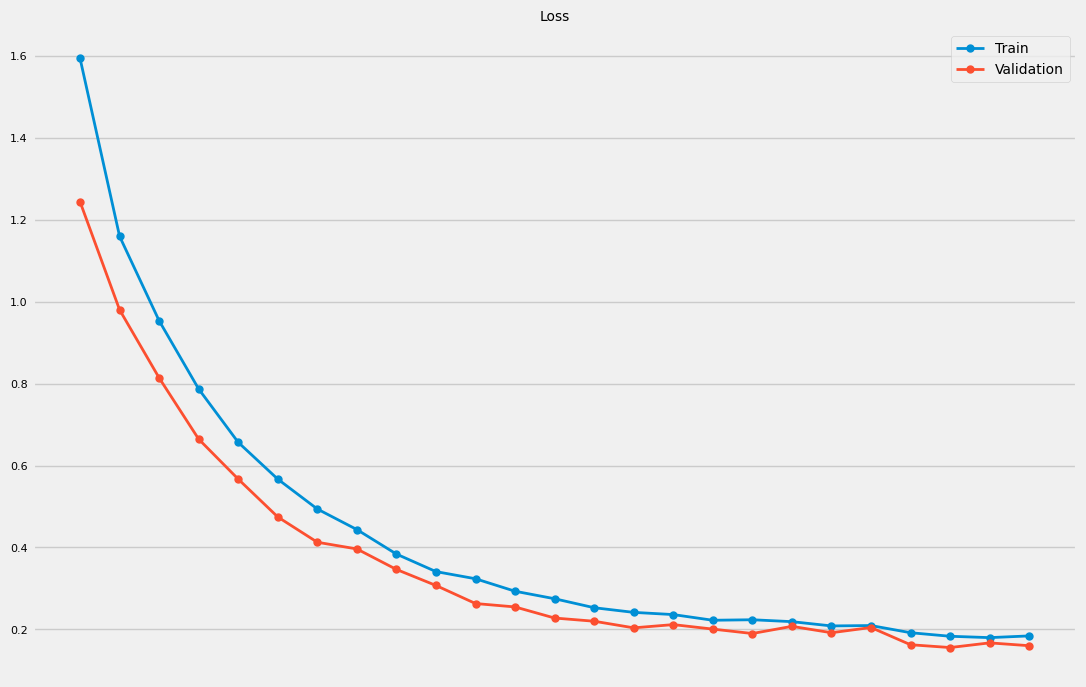

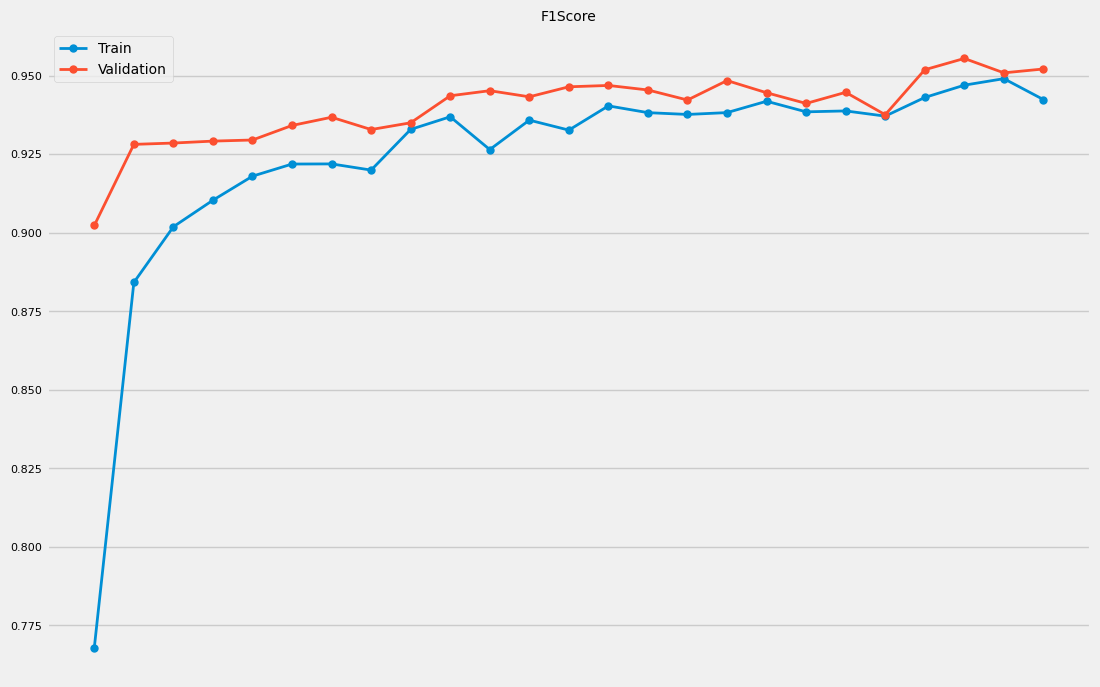

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


<Figure size 1200x600 with 0 Axes>

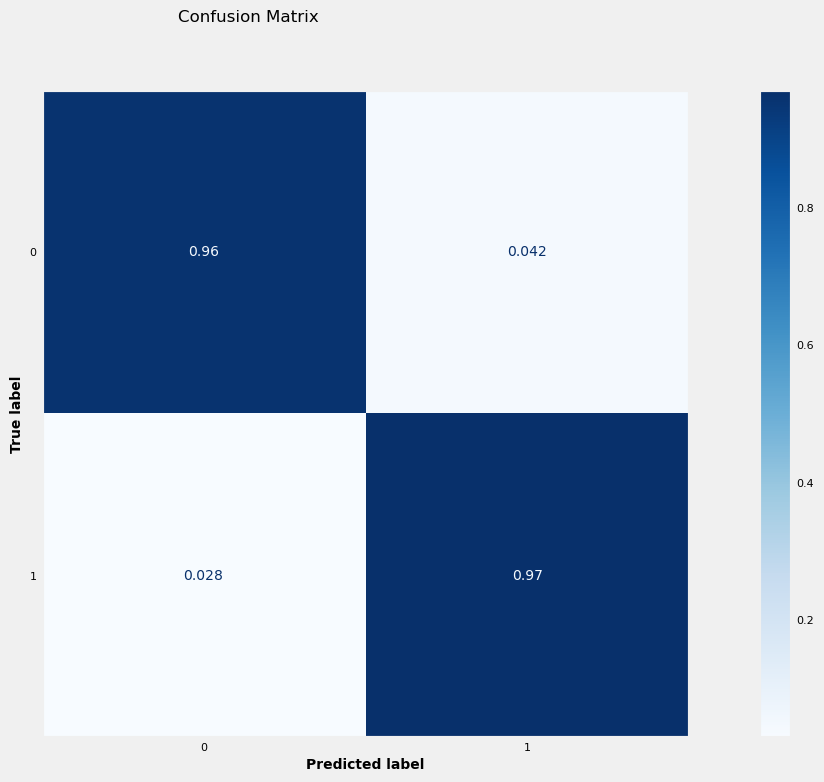

<Figure size 1200x600 with 0 Axes>

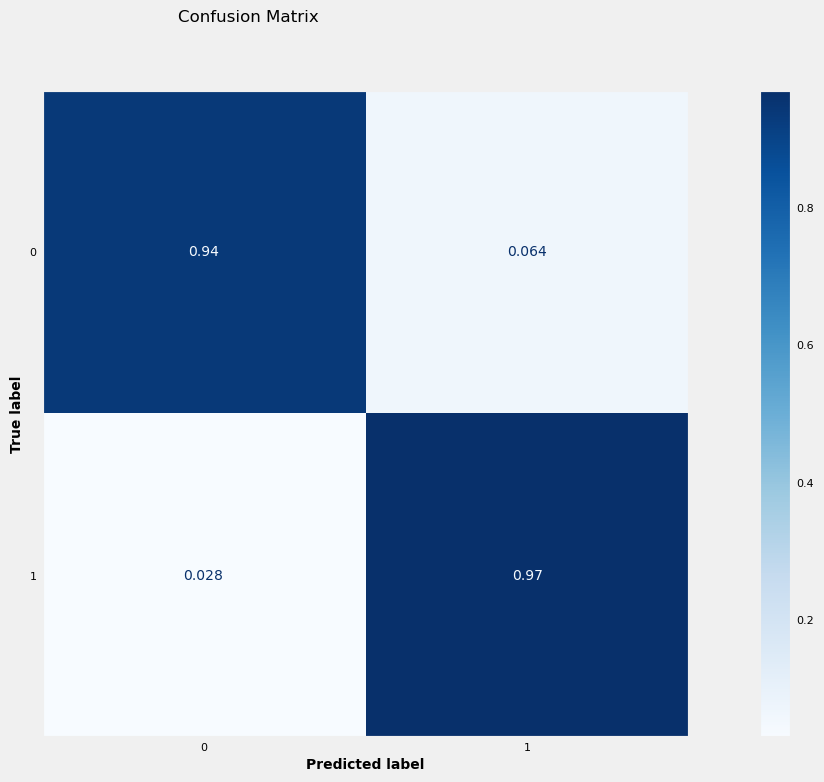

Training set accuracy:   0.968
Test set accuracy:       0.963
Training set
Class 0: precision=0.922, recall=0.958, f1_score=0.940
Class 1: precision=0.985, recall=0.972, f1_score=0.979
Test set
Class 0: precision=0.911, recall=0.936, f1_score=0.923
Class 1: precision=0.980, recall=0.972, f1_score=0.976


In [43]:
history_model0_df = pd.DataFrame(history_model0.history)
plot_measure(history_model0_df.loss, history_model0_df.val_loss, "Loss")
plot_measure(history_model0_df.f1_score, history_model0_df.val_f1_score, "F1Score")

model0.load_weights(model_file)
predictions_train_model0 = np.argmax(model0.predict(X_train), axis=-1)
predictions_test_model0 = np.argmax(model0.predict(X_test), axis=-1)

plot_confusion_matrix(y_train, predictions_train_model0)
plot_confusion_matrix(y_test, predictions_test_model0)

print_accuracy_scores(
    y_train, y_test, predictions_train_model0, predictions_test_model0
)
print_stats(y_train, predictions_train_model0, "Training set")
print_stats(y_test, predictions_test_model0, "Test set")